<a href="https://colab.research.google.com/github/RG2806/ai_spotle/blob/master/new_data_complete_with_corona_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn import model_selection, preprocessing, metrics, svm, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
!git clone https://github.com/RG2806/ai_spotle.git

Cloning into 'ai_spotle'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 4133 (delta 42), reused 36 (delta 30), pack-reused 4066
Receiving objects: 100% (4133/4133), 60.33 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (4091/4091), done.


In [3]:
import pandas as pd

import os
##combine all files in the lis
#df=pd.read_json("/content/ai_spotle/aithon2020_level_3/aithon_level_3_2020-09-22T05_11_55.txt")
df = pd.concat([pd.read_json("/content/ai_spotle/aithon2020_level_3/"+f) for c,f in enumerate(os.listdir("/content/ai_spotle/aithon2020_level_3/")) ])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496448 entries, 0 to 17660
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      496448 non-null  object
 1   location  496448 non-null  object
 2   date      496448 non-null  object
 3   time      496448 non-null  object
dtypes: object(4)
memory usage: 18.9+ MB


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def return_missing_values(data_frame):
    missing_values = data_frame['new'].isnull().sum()/len(data_frame)
    missing_values = missing_values[missing_values>0]
    #missing_values.sort_values(inplace=True)
    return missing_values

def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='whitegrid', color_codes=True)
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.xticks(rotation=90)
    plt.show()

In [42]:
return_missing_values(df)

array([], dtype=float64)

In [7]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [27]:
df['new']=df['location'].apply(lambda x: x.split(",")[-1].split(" ")[-1])

In [38]:
df['new'].value_counts().index[:20]

Index(['', 'India', 'Switzerland', 'England', 'USA', 'Kingdom', 'UK', 'CA',
       'States', 'Canada', 'Delhi', 'Pakistan', 'London', 'Netherlands',
       'VadaChennai', 'FL', 'Australia', 'Nigeria', 'Zealand', 'Kenya'],
      dtype='object')

In [37]:
udf = return_unique_values(df)
print(udf)

   Features  Uniques
0  text      13682  
1  location  3440   
2  date      10     
3  time      12442  
4  new       1624   


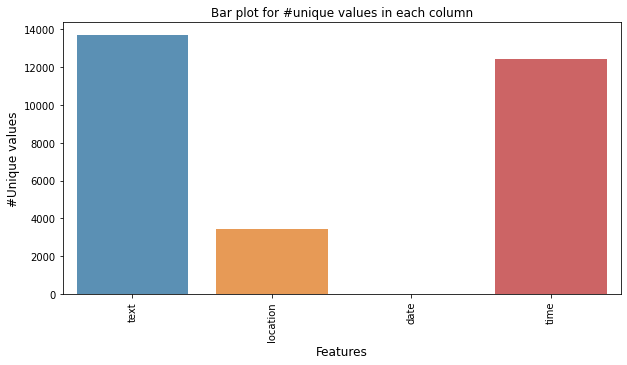

In [9]:
f, ax = plt.subplots(1,1, figsize=(10,5))#plt.figure(figsize=(10, 5))

sns.barplot(x=udf['Features'], y=udf['Uniques'], alpha=0.8)
plt.title('Bar plot for #unique values in each column')
plt.ylabel('#Unique values', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [10]:
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]
    
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 

    plt.title('Frequency of {} tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


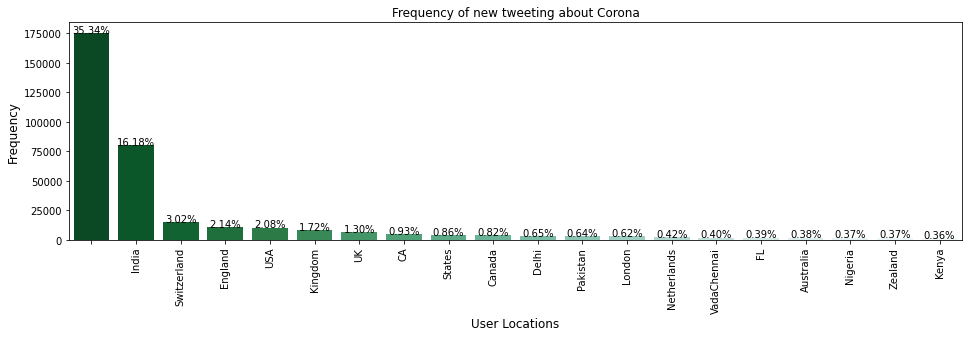

In [30]:
plot_frequency_charts(df, 'new', 'User Locations', 'BuGn_r')

In [12]:
from string import punctuation
from nltk.corpus import stopwords
print(stopwords.words('english')[10:15])

def punctuation_stopwords_removal(sms):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in sms if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_sms = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_sms

["you've", "you'll", "you'd", 'your', 'yours']


In [13]:
from collections import Counter

def draw_bar_graph_for_text_visualization(df, location):
    tweets_from_loc = df.loc[df.location==location]
    tweets_from_loc.loc[:, 'text'] = tweets_from_loc['text'].apply(punctuation_stopwords_removal)
    loc_tweets_curated = tweets_from_loc['text'].tolist()
    loc_tweet_list = []
    for sublist in loc_tweets_curated:
        for word in sublist:
            loc_tweet_list.append(word)
    loc_tweet_count = Counter(loc_tweet_list)
    loc_top_30_words = pd.DataFrame(loc_tweet_count.most_common(50), columns=['word', 'count'])
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(x='word', y='count', 
                data=loc_top_30_words, ax=ax)
    plt.title("Top 50 Prevelant Words in {}".format(location))
    plt.xticks(rotation='vertical');

In [14]:
from wordcloud import WordCloud, STOPWORDS
def draw_word_cloud(df, location, title):
    loc_df = df.loc[df.location==location]
    loc_df.loc[:, 'text'] = loc_df['text'].apply(punctuation_stopwords_removal)
    word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(loc_df['text']))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(word_cloud)
    plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


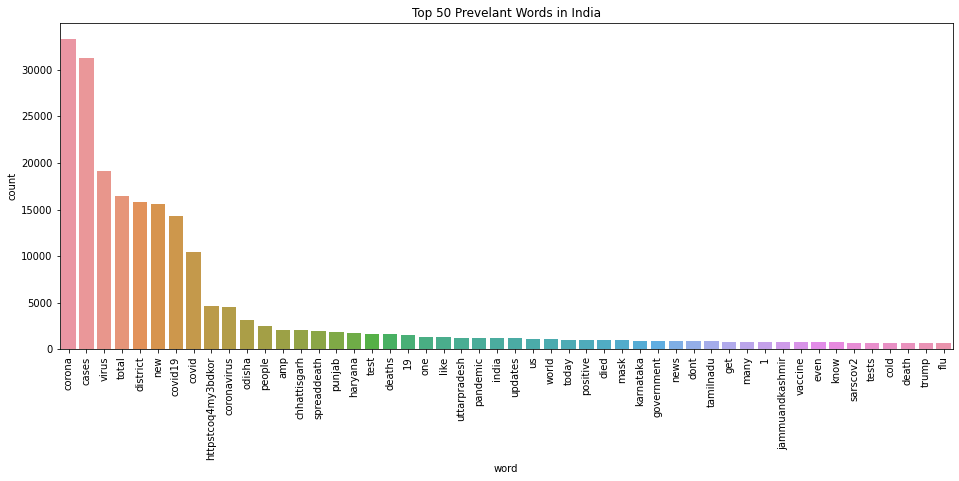

In [15]:
draw_bar_graph_for_text_visualization(df, 'India')

In [16]:
draw_word_cloud(df, 'India', 'Word Cloud for top 50 prevelant words in India')

KeyboardInterrupt: ignored

In [74]:
sentiment_df = pd.read_csv('/content/ai_spotle/finalSentimentdata2.csv')

In [75]:
sentiment_df.head()

Unnamed: 0  ...                                                                                                                                                                                                                                                                            text
0  3204        ...  agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell their family that they are fine if covid 19 case treated foc in hospitals
1  1431        ...  if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …                                                                                                                                                                                 
2  654         ...  will nature conservation remain a priority in post corona bangladesh | the daily star                                                                                                                                                                                         
3  2530        ...  coronavirus disappearing in italy show this to "intellectuals" who say lockdowns do not work …                                                                                                                                                                                
4  2296        ...  uk records lowest daily virus death toll since start of lockdown govt                                                                                                                                                                                                         

[5 rows x 3 columns]

In [76]:
num_classes = 4

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sad']

In [81]:
!pip3 install ktrain

     |████████████████████████████████| 25.3MB 128kB/s 
     |████████████████████████████████| 983kB 51.3MB/s 
     |████████████████████████████████| 245kB 50.0MB/s 
     |████████████████████████████████| 1.1MB 47.0MB/s 
     |████████████████████████████████| 471kB 46.7MB/s 
     |████████████████████████████████| 1.1MB 47.7MB/s 
     |████████████████████████████████| 3.0MB 46.9MB/s 
     |████████████████████████████████| 890kB 46.3MB/s 
  Created wheel for ktrain: filename=ktrain-0.21.4-cp36-none-any.whl size=25270024 sha256=17897184c3dfc82285d475be6ae6fd1deda3963eaa0e143e595522e4251d3428
  Stored in directory: /root/.cache/pip/wheels/e8/b6/c2/a730bb7727f9402827eb9cdd277a527a4a88acb2b0d22f06f0
  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=f7a29b7ed535c103c015c01b64151e2a67b89630c3584f7932c56ace366d8620
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for lan

In [84]:
import ktrain
from ktrain import text
data_train =  sentiment_df[:2472]
data_test = sentiment_df[2472:]

X_train = data_train.text.tolist()
X_test = data_test.text.tolist()

y_train = data_train.sentiment.tolist()
y_test = data_test.sentiment.tolist()

data = data_train.append(data_test, ignore_index=True)

class_names = ['joy', 'sad', 'fear', 'anger']

print('size of training set: %s' % (len(data_train['text'])))
print('size of validation set: %s' % (len(data_test['text'])))
print(data.sentiment.value_counts())
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]
data.head(10)

size of training set: 2472
size of validation set: 618
fear     801
sad      795
anger    767
joy      727
Name: sentiment, dtype: int64


Unnamed: 0  ...                                                                                                                                                                                                                                                                            text
0  3204        ...  agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell their family that they are fine if covid 19 case treated foc in hospitals
1  1431        ...  if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …                                                                                                                                                                                 
2  654         ...  will nature conservation remain a priority in post corona bangladesh | the daily star                                                                                                                                                                                         
3  2530        ...  coronavirus disappearing in italy show this to "intellectuals" who say lockdowns do not work …                                                                                                                                                                                
4  2296        ...  uk records lowest daily virus death toll since start of lockdown govt                                                                                                                                                                                                         
5  4624        ...  joe biden's coronavirus web address lands on a donation page for his campaign he is profiting from fear demopos                                                                                                                                                               
6  2596        ...  respected sir in our telangana all private teachers and lecturers are in horrible situations due to covid 19 and mainly private management (chaithanya nd narayana) b'caz they told to all faculty's like “no work no pay “ so pls take the action nd save their life's       
7  4131        ...  so is also 20 times more lethal than influenza think about that                                                                                                                                                                                                               
8  3184        ...  thull is passing the most dangerous and ultra hazardous situation in its history 80% population of thul town and surrounding have been striked by corona virus cm/health m sindh to take notice we plead the govt to pay attention to thul retweet &share                     
9  3175        ...  thull is passing the most dangerous and ultra hazardous situation in its history 80% population of thul town and surrounding have been striked by corona virus cm/health m sindh to take notice we plead the govt to pay attention to thul retweet&share                      

[10 rows x 3 columns]

In [85]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350, 
                                                                       max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [86]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350
done.


In [87]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

In [88]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
412/412 [==============================] - 312s 757ms/step - loss: 1.0576 - accuracy: 0.5303 - val_loss: 0.7856 - val_accuracy: 0.6845
Epoch 2/3
412/412 [==============================] - 311s 755ms/step - loss: 0.6034 - accuracy: 0.7698 - val_loss: 0.6478 - val_accuracy: 0.7362
Epoch 3/3
412/412 [==============================] - 313s 759ms/step - loss: 0.2449 - accuracy: 0.9134 - val_loss: 0.6175 - val_accuracy: 0.7848


In [89]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

              precision    recall  f1-score   support

         joy       0.90      0.86      0.88       135
         sad       0.74      0.69      0.72       171
        fear       0.72      0.76      0.74       159
       anger       0.80      0.85      0.83       153

    accuracy                           0.78       618
   macro avg       0.79      0.79      0.79       618
weighted avg       0.79      0.78      0.78       618



['joy', 'sad', 'fear', 'anger']

In [90]:
import pandas as pd

import os
##combine all files in the lis
#df=pd.read_json("/content/ai_spotle/aithon2020_level_3/aithon_level_3_2020-09-22T05_11_55.txt")
df = pd.concat([pd.read_json("/content/ai_spotle/aithon2020_level_3/"+f) for c,f in enumerate(os.listdir("/content/ai_spotle/aithon2020_level_3/")) ])

In [91]:
tok = WordPunctTokenizer()
lemma = WordNetLemmatizer()
# patterns to remove html tags numbers and special Characters
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
op = r'\bcovid\b\s+'
combined_pat = r'|'.join((pat1, pat2))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
shortcuts_pattern = re.compile(r'\b(' + '|'.join(shortcuts.keys()) + r')\b')
def clean_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)#for removing patterns like #,@ and punctuation
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    shortcuts_handled = shortcuts_pattern.sub(lambda x: shortcuts[x.group()],neg_handled)
    letters_only = re.sub("[^a-zA-Z]", " ", shortcuts_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    lemmated_words = [lemma.lemmatize(word) for word in words]
    return (" ".join( lemmated_words)).strip()

In [92]:
df=df.drop_duplicates('text')
#df=df[df['location'].apply(lambda x: x.lower().find("india")>-1)]
df['cleaned_tweets'] = df['text'].apply(lambda x: clean_text(x))

In [93]:
print(df.shape)
df.head()

(13682, 5)


text  ...                                                                                                                                                                                                                                     cleaned_tweets
0  COVID-19 claims 6 more lives, infects 194 others: CM Sindh \n\n#APPNews @MuradAliShahPPP #coronavirus #Corona #CoronavirusPandemic \n\nhttps://t.co/M9brEO1Ghh via appcsocialmedia                                                                                                                     ...  covid claim more life infects others cm sindh appnews coronavirus corona coronaviruspandemic via appcsocialmedia                                                                                                                                 
1  @AlyssaCoachala @thehill "deliberately embellished Corona virus"🤣\n\nTRUMP: \n\n"You just breathe the air and that’s how it’s passed.” \n“COVID is much more deadly than even your strenuous flu.” “This is deadly stuff”\n\n“5% death rate”                                                           ...  deliberately embellished corona virus trump you just breathe the air and that how it passed covid is much more deadly than even your strenuous flu this is deadly stuff death rate                                                               
2  Covid-19 era diplomacy. Having Barents Euro-Arctic Council Senior Officials meeting in virtual format. Determined to further develop our cooperation despite the currents restrictions. Good discussion on future priorities on climate change beyond corona. ⁦@barents_beac⁩ https://t.co/ulJkUIDnPE  ...  covid era diplomacy having barents euro arctic council senior official meeting in virtual format determined to further develop our cooperation despite the current restriction good discussion on future priority on climate change beyond corona
3  @WINDOCTORRX Operation Corona was about hysteria and fear to falsely justify mail-in voting to fraud the election. That's why all deaths were listed as 'covid' with medical industry awarded a bounty for each death. https://t.co/1UyDI8OcIK                                                         ...  operation corona wa about hysteria and fear to falsely justify mail in voting to fraud the election that why all death were listed a covid with medical industry awarded bounty for each death                                                   
4  The neighborhood  kids can be  so funny!\nA stray dog has delivered 3 puppies.\nThe kids have named the mother Corona.......and the puppies are called Covid, Virus and Flu!! 🙆‍♀️🤦‍♀️\n#Humourinlife                                                                                                  ...  the neighborhood kid can be so funny stray dog ha delivered puppy the kid have named the mother corona and the puppy are called covid virus and flu humourinlife                                                                                 

[5 rows x 5 columns]

In [94]:
df['analysis'] = df['cleaned_tweets'].apply(lambda x : predictor.predict(x))

In [96]:
df.groupby('analysis').count()

text  location  date  time  cleaned_tweets
analysis                                            
anger     6202  6202      6202  6202  6202          
fear      1865  1865      1865  1865  1865          
joy       3314  3314      3314  3314  3314          
sad       2301  2301      2301  2301  2301

text  ... analysis
0   COVID-19 claims 6 more lives, infects 194 others: CM Sindh \n\n#APPNews @MuradAliShahPPP #coronavirus #Corona #CoronavirusPandemic \n\nhttps://t.co/M9brEO1Ghh via appcsocialmedia                                                                                                                        ...  sad    
5   September 22nd,2020 corona update, Nepal\n2 New deaths, \n823 Recovered, \n1356 new cases of COVID-19 Confirmed\nTotal Cases: 66632, \nActive Cases: 18571, \nTotal Deaths: 429,\nPCR tests on 22nd September: 11154\nTotal PCR tests: 934977                                                             ...  sad    
10  Does art still hold a place during times when people are more focused on their struggle to survive the COVID-19 pandemic? #digitalmarketingagency https://t.co/MPbzG0bfGY https://t.co/x1OQN48mJM                                                                                                         ...  sad    
11  September 21st,2020 corona update, Nepal\n16 New deaths, \n1005 Recovered, \n1154 new cases of COVID-19 Confirmed\nTotal Cases: 65276, \nActive Cases: 18038, \nTotal Deaths: 427,\nPCR tests on 21st September: 9533\nTotal PCR tests: 923823                                                            ...  sad    
12  Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/t22nKsfPgA                           ...  sad    
13  Covid news\n\nBangladesh has become the 29th nation to lose 5000 people to the virus.\n\n100 countries have now reported over 9000 cases of Corona. \nPoland is the 44th nation with over 80,000 cases and  Indonesia is the 23rd nation to report a quarter of a million cases. https://t.co/oqGySpaZb6  ...  sad    
16  Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/6eImJKTtpH                           ...  sad    
17  Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/6V7SRzhMe4                           ...  sad    
21  Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/Dxxwycj1zi                           ...  sad    
22  Scaling up the state’s fight against #COVID, Chief Minister @capt_amarinder Singh launched the Corona Fateh Kits, which the state government will start distributing immediately to all #COVID patients in isolation, whether at home or in hospitals.\nhttps://t.co/yPT3bYFqOJ                           ...  sad    

[10 rows x 6 columns]

In [ ]:
You can access specific tweets by their id with the statuses/show/:id API route. Most Python Twitter libraries follow the exact same patterns, or offer 'friendly' names for the methods.

For example, Twython offers several show_* methods, including Twython.show_status() that lets you load specific tweets:

CONSUMER_KEY = "<consumer key>"
CONSUMER_SECRET = "<consumer secret>"
OAUTH_TOKEN = "<application key>"
OAUTH_TOKEN_SECRET = "<application secret"
twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

tweet = twitter.show_status(id=id_of_tweet)
print(tweet['text'])